# Project 2 Final Notebook

## Stakeholder and Business Problem - **Howard S Wright Construction Company**

Howard S Wright is a well-known construction company that is prevalent within the King County area. Howard S Wright wants to know what ***features*** that they should focus on in order to maximize their profit when building a new home in King County.<br />
Some factors that we intitially thought that Howard S Wright should focus on were:
- Square Footage (specifically the building footprint and the total living space)
- Location
- Numbers of beds and bathrooms
- Quality of the home

In this notebook, we will explore and analyze the data in order to provide the best features and recommendations for Howard S Wright to consider in order to maximize their profit when building a new home.

# Exploratory Data Analysis

In [1]:
# Imported appropriate libraries for use in this notebook and our multilinear regression modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker

### Created functions to help with ease of access in our linear regression analysis

In [2]:
# evaluates the metrics for the statsmodel linear regression model and prints out the values for easy visualization

def sm_metrics(model, y, X):
    # import associated tools
    from statsmodels.tools.eval_measures import rmse, mse, meanabs
    
    # now generate predictions
    ypred = model.predict(X)

    # Print values
    print('Metrics:')
    # MAE
    print(f"Mean Absolute Error: {meanabs(y, ypred):.3f}")
    # MSE
    print(f"Mean Squared Error: {mse(y, ypred):.3f}")
    # RMSE
    print(f"Root Mean Squared Error: {rmse(y, ypred):.3f}")
    return

In [3]:
# evaluates the metrics for the scikitlearn linear regression model and prints out the values for easy visualization

def sk_metrics(y, model):
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    print("Metrics:")
    # R2
    print(f"R2: {r2_score(y, model):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y, model):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y, model):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y, model, squared=False):.3f}")
    return

In [4]:
# evaluates and displays a qqplot

def qq(x_test, x_train, y_test, y_train):
    # QQ plots are generally great tools for checking for normality.
    import statsmodels.api as sm
    from sklearn.linear_model import LinearRegression
    
    # Calculating residuals
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_hat = lr.predict(x_test)
    
    residuals = y_test - y_hat
    
    
    sm.qqplot(residuals, line = 'r');
    return

In [5]:
# evaluates the Variance Inflation Factor of X_train variables

def vif(X_train):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # defining an empty dataframe to capture the VIF scores
    vif = pd.DataFrame()

    # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

    # label the scores with their related columns
    vif["features"] = X_train.columns
    
    # print out the vif table and return
    print(vif)
    return

In [6]:
# evaluates the model metrics of a linear regression model

def lr_model_metrics(x_test, x_train, y_test, y_train, cat_vars): 
    # One hot encoding cat vars
    onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
    x_train_cat = pd.DataFrame(onehot.fit_transform(x_train[cat_vars]))
    x_train_cat.columns = onehot.get_feature_names(cat_vars)
    x_test_cat = pd.DataFrame(onehot.transform(x_test[cat_vars]))
    x_test_cat.columns = onehot.get_feature_names(cat_vars)
    
    # Resetting indices to avoid joining conflicts and creation of NaN entries
    x_train_cat.reset_index(drop=True, inplace=True)
    x_test_cat.reset_index(drop=True, inplace=True)
    x_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    
    # Combine dummied cat vars with non-cat
    x_train_df = x_train_cat.join(x_train.drop(cat_vars, axis = 1))
    x_test_df = x_test_cat.join(x_test.drop(cat_vars, axis = 1))
    
    # Run linear regression model for data
    lr = LinearRegression()
    model = lr.fit(x_train_df, y_train)
    
    print('Train Data')
    sk_metrics(y_train, model.predict(x_train_df.values))
    
    print('Test Data')
    sk_metrics(y_test, model.predict(x_test_df.values))
    return x_train_df, x_test_df, model

We utilized the `kc_house_data` as well as demographics data `demographic_spatial_join.xls` that we acquired online from King County's census data. We utilized a GIS software in order to retrieve the specific data that we needed.

Performing some basic initial exploratory data analysis to see what data we're working with. We also want to check if there are any missing data values that we need to take into consideration when performing our modeling and analysis.

In [7]:
housedf = pd.read_csv('data/kc_house_data.csv')

In [8]:
housedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [9]:
housedf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [10]:
housedf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Created a few dataframes for different use cases:
- **dfinit**: used to drop columns that we were not utilizing in our model/data analysis (mostly categorical columns).
- **dfrev1**: used to drop numerical columns.
- **dfrevcopy**: used for testing some modeling so that we didn't have to re-run everything if a mistake was made.

We also engineered some features and added them to the original housedf dataframe:
- **sqft_per_bedroom**: the sqft_living divided by bedrooms value for avg sqft per bedroom.
- **footprint**: the sqft_living divided by sqft_lot for relative sqft of usage.
- **bedbathratio**: the number of bedrooms divided by bathrooms since these values have high multicollinearity.

In [11]:
housedf.drop_duplicates(keep= 'first', inplace = True)
dfinit = housedf.drop(['id', 'date', 'yr_renovated', 'condition', 'waterfront', 'lat', 'long', 
                 'sqft_above', 'sqft_basement', 'view'], axis=1).copy()
# Created duplicate dataframes so that we could work on data without accidentally affecting original dataframe.                                   
dfrev1 = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
dfrevcopy = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()

# Feature engineered sqft_per_bedroom as a data column since for our stakeholder, knowing the avg sqft per bedroom in a home
# would be useful in deciding which direction to go for homebuilding.
housedf['sqft_per_bedroom'] = housedf['sqft_living'] / housedf['bedrooms']

# Feature engineered the footprint column to visualized the relationship between sqft of living and the lot size so that our 
# stakeholder would know on avg what home sizes they would be working with.
housedf['footprint'] = housedf['sqft_living'] / housedf['sqft_lot']

# Feature engineered the bedbathratio since they have decently high multicollinearity - combining them together in the bed/bath
# ratio might give us a better R^2 value
housedf['bedbathratio'] = housedf['bedrooms'] / housedf['bathrooms']

# Printed out housedf just to check that columns were added correctly
housedf

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint,bedbathratio
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,393.333333,0.208850,3.000000
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,856.666667,0.354874,1.333333
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,385.000000,0.077000,2.000000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,490.000000,0.392000,1.333333
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,560.000000,0.207921,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,2009,0.0,98103,47.6993,-122.346,1530,1509,510.000000,1.352785,1.200000
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2014,0.0,98146,47.5107,-122.362,1830,7200,577.500000,0.397385,1.600000
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,2009,0.0,98144,47.5944,-122.299,1020,2007,510.000000,0.755556,2.666667
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,2004,0.0,98027,47.5345,-122.069,1410,1287,533.333333,0.670017,1.200000


We pulled kc_zips information from the [King County Website](https://kingcounty.gov/services/gis.aspx). We identified the unique zipcode values and created a list with those values to use in our modeling. After creating this new dataframe, we did intiial exploratory data analysis in a similar fashion for this dataset as we did for the `kc_house_data.csv`

In [12]:
kc_zips = [98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198,
           98146, 98038, 98007, 98115, 98107, 98126, 98019, 98103, 
           98002, 98133, 98040, 98092, 98030, 98119, 98112, 98052, 
           98027, 98117, 98058, 98001, 98056, 98166, 98023, 98070, 
           98148, 98105, 98042, 98008, 98059, 98122, 98144, 98004, 
           98005, 98034, 98075, 98116, 98010, 98118, 98199, 98032, 
           98045, 98102, 98077, 98108, 98168, 98177, 98065, 98029, 
           98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031, 
           98106, 98072, 98188, 98014, 98055, 98039]

In [13]:
df2 = pd.read_excel('data/demographic_spatial_join.xls')

b_series = df2.ZCTA5CE10.isin(kc_zips)
df_zips = df2[b_series]

df_names = df_zips[['ZCTA5CE10', 'NAME']]
df_names.head()

,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest


In [14]:
df_names.NAME.value_counts()

Northeast    33
West         29
Southeast    26
Southwest    17
Shoreline    12
Name: NAME, dtype: int64

In [15]:
df_names


,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest
...,...,...
138,98188,Southeast
139,98188,Southwest
141,98198,Southeast
142,98198,Southwest


In [16]:
# Dropping duplicates randomly, for the moment
df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)
df_names.ZCTA5CE10

<ipython-input-16-af7d0a158eea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)


0      98001
2      98002
3      98003
5      98004
6      98005
       ...  
131    98177
135    98178
138    98188
141    98198
143    98199
Name: ZCTA5CE10, Length: 70, dtype: int64

In [17]:
# lists of zipcodes
northeast = df_names.query('NAME=="Northeast"')['ZCTA5CE10'].to_list()
west = df_names.query('NAME=="West"')['ZCTA5CE10'].to_list()
shoreline = df_names.query('NAME=="Shoreline"')['ZCTA5CE10'].to_list()
southwest = df_names.query('NAME=="Southwest"')['ZCTA5CE10'].to_list()
southeast = df_names.query('NAME=="Southeast"')['ZCTA5CE10'].to_list()
print("Northeast: ", northeast)
print("Shoreline: ", shoreline)

Northeast:  [98004, 98005, 98006, 98007, 98008, 98011, 98014, 98019, 98024, 98027, 98028, 98029, 98033, 98034, 98038, 98039, 98040, 98045, 98052, 98053, 98056, 98059, 98065, 98072, 98074, 98075, 98077]
Shoreline:  [98125, 98133, 98155, 98177]


In [18]:
# Create new  DF for revisions, change type
dfrev2 = dfrev1.copy()
# use lists to make categorical bins
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=northeast, value = "Northeast")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=west, value = "West")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=shoreline, value = "Shoreline")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southwest, value = "Southwest")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southeast, value = "Southeast")

dfrev2.zipcode.value_counts()

Northeast    8560
West         4442
Southeast    4126
Southwest    2866
Shoreline    1603
Name: zipcode, dtype: int64

# Model Creation and Application

Created training and test datasets for the housedf dataframe. Utilized a 80 / 20 split.

After each model that we run, we will assess the metrics, qqplots, and heteroskedasticity to check and see if the modeling that we performed was done correctly or not. We also assess these metrics in order to assess if the data is normally distributed or not.

In [19]:
y = housedf['price']
X = housedf[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode',
             'sqft_per_bedroom', 'footprint', 'bedbathratio']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

## Dummy Regressor

Created a Dummy Regressor on the mean for use as our baseline model. 
- We used the predict function on our baseline model to check if the printed out array was filled with the same values or not.
- We then checked the score of the baseline model. We know that the score should give us a 0 since it is only accounting for the intercepts. Since this is our *baseline model*, we will be comparing all of our other models to this as a measurement of success.

In [20]:
#Dummy Regressor

basemodel = DummyRegressor(strategy = 'mean')
basemodel.fit(X_train, y_train)
basemodel.predict(X_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

In [21]:
basemodel.score(X_train, y_train)

0.0

We defined the `sk_metrics` function at the beginning of our notebook, and by calling it on our `y_train` and basemodel we can evaluate the initial R^2 and RMSE value of our basemodel. These are the baseline scores that we are going to be comparing our future models to in order to gauge model 
success.

In [22]:
sk_metrics(y_train, basemodel.predict(X_train))

Metrics:
R2: 0.000
Mean Absolute Error: 233710.087
Mean Squared Error: 135491967490.227
Root Mean Squared Error: 368092.336


In [23]:
sk_metrics(y_test, basemodel.predict(X_test))

Metrics:
R2: -0.000
Mean Absolute Error: 236167.828
Mean Squared Error: 132800122046.262
Root Mean Squared Error: 364417.511


## StandardScalar and OneHotEncoder

Created a StandardScalar for our dataset because we had data values such as 1 bedroom vs. thousands of sqft. We wanted to see a normal distribution of our data in order to have a more accurate representation of our dataset as a whole.

In [24]:
X_train_plus_y = pd.concat((X_train, y_train), axis=1)
X_test_plus_y = pd.concat((X_test, y_test), axis=1)
ss = StandardScaler()
ss.fit(X_train)

StandardScaler()

Created a OneHotEncoder for our initial model 

In [25]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train)

<17277x26611 sparse matrix of type '<class 'numpy.float64'>'
	with 172770 stored elements in Compressed Sparse Row format>

Created a training data sat based on the StandardScalar values and our training/test split. We reset the index at the end of each training/test split to avoid any join conflicts/creation of NaNs that would increase number of entries in our dataset.


In [26]:
# Training dataset
X_train_scaled = pd.DataFrame(ss.transform(X_train))
X_train_scaled.columns = X.columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_plus_y = pd.concat((X_train_scaled, y_train), axis=1)
X_train.reset_index(drop=True, inplace=True)

Created the test dataset based on our StandardScalar values and our training/test split

In [27]:
# Testing dataset
X_test_scaled = pd.DataFrame(ss.transform(X_test))
X_test_scaled.columns = X.columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_plus_y = pd.concat((X_test_scaled,y_test),axis=1)
X_test.reset_index(drop=True, inplace=True)

## First Model - our initial multilinear regression model

Created our first model based on the values in our heatmap that had the highest correlation with price, in this case that was the sqft_living + bedrooms + floors columns. We will then use this first model to check and see if the predictors have any significant impact on the price of the homes.

## Correlation and Heatmap Visualization

Prior to running the model on our datasets, we had to check the data for any correlation or multicollinearity so that we could accomodate for that in our model. 

In [28]:
housedf.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint,bedbathratio
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.011922,0.088238,-0.014457
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,0.580109,0.123063,-0.249948
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.024076,0.026798,0.209444
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,0.517415,0.287015,-0.653476
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,0.755398,0.076988,-0.324152
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.190583,-0.252601,-0.050648
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.290654,0.556700,-0.374139
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077,0.671149,0.051612,-0.317922
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777,0.257801,0.279053,-0.437429
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852,0.063348,-0.001743,-0.034499


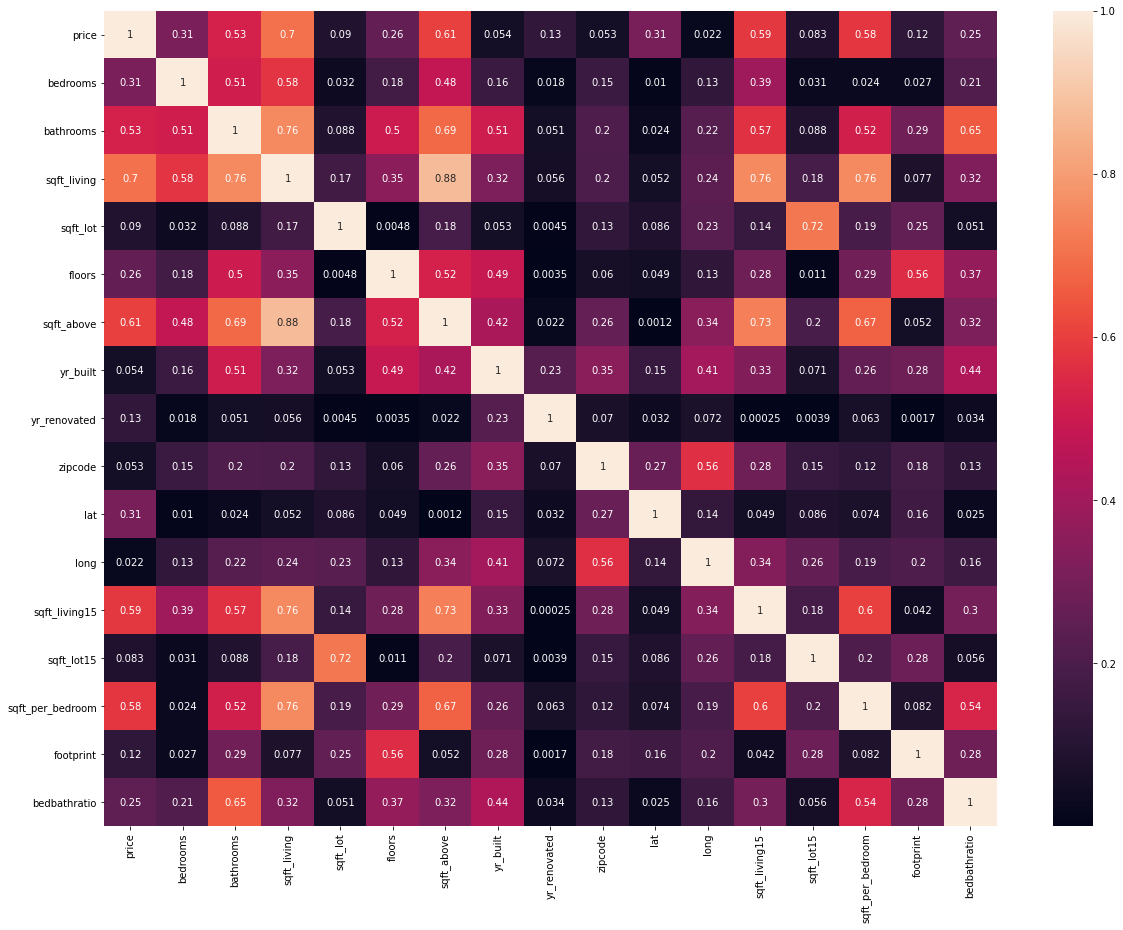

In [29]:
plt.figure(figsize = (20,15))
sns.heatmap(housedf.drop(['id'], axis = 1).corr().abs(), annot=True);

In [30]:
# Keep first model as sqft_living + bedrooms + floors to show that was our first model and how we progressed
# 2nd model should be 'price ~ sqft_living + bedrooms + sqft_per_bedroom + footprint' to show the increase of R^2
formula = 'price ~  sqft_living + bedrooms + floors'
model = ols(formula, X_train_scaled_plus_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5874.
Date:                Sun, 20 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:36:37   Log-Likelihood:            -2.3986e+05
No. Observations:               17277   AIC:                         4.797e+05
Df Residuals:                   17273   BIC:                         4.798e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.409e+05   1970.511    274.521      0.000    5.37e+05    5.45e+05
sqft_living  2.882e+05   2530.414    113.894      0.000    2.83e+05    2.93e+05
bedrooms    -5.411e+04   2402.875    -22.520      0.000   -5.88e+04   -4.94e+04
floors       1412.8026   2110.123      0.670      0.503   -2723.252    5548.857
==============================================================================
Omnibus:                    11809.269   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           435749.399
Skew:                           2.803   Prob(JB):                         0.00
Kurtosis:                      26.956   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After running the model, we see that sqft_living and bedrooms are a significant factor in determining the price of a home. Since the p-value of floors > 0.05, we can say that floors are not a significant factor in determining the price of a home. This pertains to our business question since the lots of land themselves are expensive, but homes are cheaper to build vertically.

Once again calling the function `sm_metrics` that we defined earlier to find the metrics of our model. We prioritize/focus on RMSE because it provides us with more accuracy. The values represented in these metrics make sense since we are dealing with homes that are in the hundreds of thousands range.

In [31]:
sm_metrics(model, y_test, X_test_scaled)

Metrics:
Mean Absolute Error: 169584.127
Mean Squared Error: 64475389966.508
Root Mean Squared Error: 253920.046


We then calculate the predicted values of our models to calculate the residuals and see if our models were implemented correctly.

In [32]:
y_hat = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled)

We calculate the residuals

In [33]:
residuals = (y_train - y_hat)
print(residuals)

0        134054.190256
1       -177151.427931
2        -39418.666228
3        211972.734232
4       -284322.633742
             ...      
17272   -108179.962734
17273    -18228.613749
17274   -141713.668295
17275    -61076.700318
17276     34848.286680
Length: 17277, dtype: float64


Then we plot a qqplot to visualize the residuals and see where our error lies. We see that some of our residuals break off towards the left and right side of the plot; however, for the most part, most of our residuals lie along the line. 

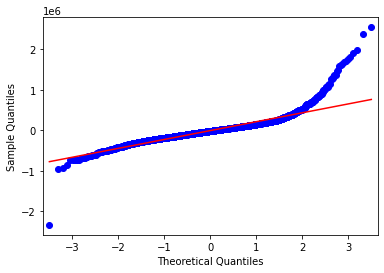

In [34]:
qq(X_test_scaled, X_train_scaled, y_test, y_train)

Plotted a heteroskedasticity plot for visualization of any recognizable patterns to check if our model was ran correctly.

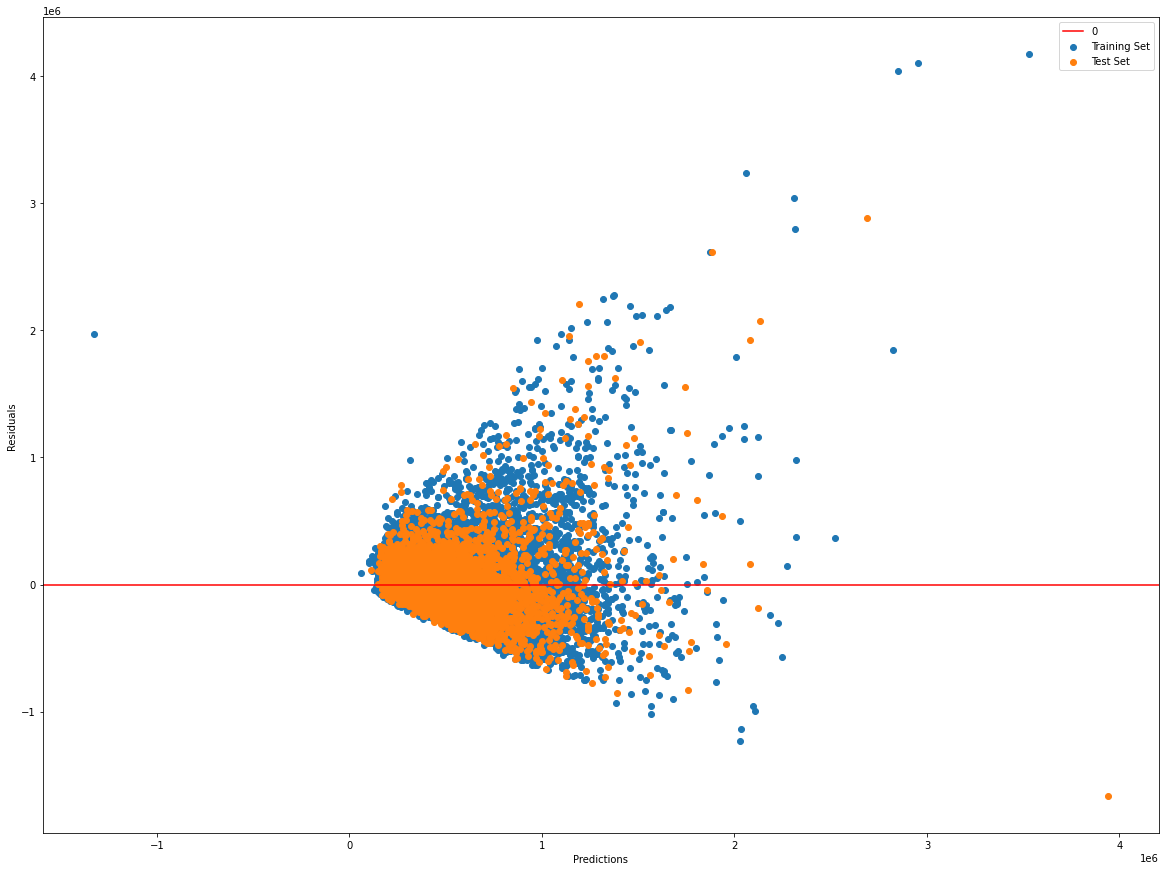

In [35]:
plt.figure(figsize = (20,15))
plt.scatter(y_hat, y_train - y_hat, label = 'Training Set')
plt.scatter(y_pred, y_test - y_pred, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

We see after plotting the heterskedasticity of our plots that a funnel pattern is a semi-recognizable. This means that our data is not normally distributed, so we have to log our data in order to get a normalized plot. We will apply this finding to our future models.

In [36]:
X_train_scaled.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint,bedbathratio
bedrooms,1.000000,0.509423,0.571636,0.026344,0.178529,0.154396,-0.152053,-0.024644,0.030371,0.217513
bathrooms,0.509423,1.000000,0.752564,0.085556,0.503355,0.511066,-0.205060,0.517643,0.289180,-0.653090
sqft_living,0.571636,0.752564,1.000000,0.170260,0.356378,0.320881,-0.201041,0.759121,0.077961,-0.324053
sqft_lot,0.026344,0.085556,0.170260,1.000000,-0.001869,0.053034,-0.128976,0.194870,-0.250546,-0.049564
floors,0.178529,0.503355,0.356378,-0.001869,1.000000,0.488497,-0.058795,0.293768,0.553484,-0.373462
yr_built,0.154396,0.511066,0.320881,0.053034,0.488497,1.000000,-0.347291,0.261316,0.279235,-0.440836
zipcode,-0.152053,-0.205060,-0.201041,-0.128976,-0.058795,-0.347291,1.000000,-0.124074,0.177918,0.126029
sqft_per_bedroom,-0.024644,0.517643,0.759121,0.194870,0.293768,0.261316,-0.124074,1.000000,0.080342,-0.537891
footprint,0.030371,0.289180,0.077961,-0.250546,0.553484,0.279235,0.177918,0.080342,1.000000,-0.278224
bedbathratio,0.217513,-0.653090,-0.324053,-0.049564,-0.373462,-0.440836,0.126029,-0.537891,-0.278224,1.000000


We then check the VIF to see if we missed anything about multicollinearity between the variables.

In [37]:
# Check the VIFs after running the model to see if any values are > 10
vif(X_train_scaled)

         VIF          features
0   8.133196          bedrooms
1  10.414278         bathrooms
2  15.034290       sqft_living
3   1.142210          sqft_lot
4   1.955622            floors
5   1.739823          yr_built
6   1.276777           zipcode
7   9.195762  sqft_per_bedroom
8   1.764403         footprint
9   6.343995      bedbathratio


Our initial model produced an R^2 value of 0.505. Of our intiial predictors, we identified that sqft_living and bedrooms were significant in accounting for the variation in price while floors was **NOT** significant in the variation of price (due to its extremely high P value). In our next model, we are going to identify the predictors that we engineered.

## Second Model - reducing complexity

We engineered some features (such as sqft_living, bedbathratio, etc.) since we saw that some predictors exhibited multicollinearity with each other. Our goal is to create an optimized model that will reduce the complexity but also cover as much ground as possible. We wanted to see if removing these predictors would reduce the complexity and thus increase the efficiency of our model. 
- Some of the initial predictors that we had in our intial dataset (such as bedrooms and bathrooms) had multicollinearity with each other so we decided to remove them from our 2nd model.

In [38]:
formula2 = 'price ~  sqft_living + sqft_per_bedroom + footprint + bedbathratio'
model2 = ols(formula2, X_train_plus_y).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     4354.
Date:                Sun, 20 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:36:39   Log-Likelihood:            -2.3992e+05
No. Observations:               17277   AIC:                         4.798e+05
Df Residuals:                   17272   BIC:                         4.799e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -1.93e+05   1.26e+04    -15.347      0.000   -2.18e+05   -1.68e+05
sqft_living        240.5972      3.365     71.492      0.000     234.001     247.194
sqft_per_bedroom   248.7397     16.059     15.489      0.000     217.263     280.217
footprint         1.062e+05   7706.949     13.781      0.000    9.11e+04    1.21e+05
bedbathratio      2.561e+04   3731.289      6.865      0.000    1.83e+04    3.29e+04
==============================================================================
Omnibus:                    12444.927   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           551350.015
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      30.029   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
# Check the VIFs after running the model to see if any values are > 10
vif(X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])

        VIF          features
0  2.429858       sqft_living
1  3.082085  sqft_per_bedroom
2  1.097728         footprint
3  1.570652      bedbathratio


Created a scatter matrix to check for distribution and heteroskedasticity.

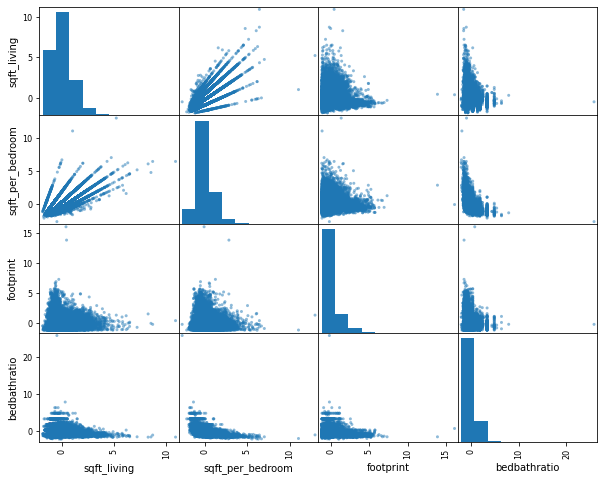

In [40]:
pd.plotting.scatter_matrix(X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']], figsize = (10,8));

We now run the second model to see if there were any changes to the R^2 value. We also wanted to test and see if keeping the bedrooms/bathrooms variables would reduce the complexity of our models. Removing the bedrooms variable in our model reduces our R^2 value by 0.015. 

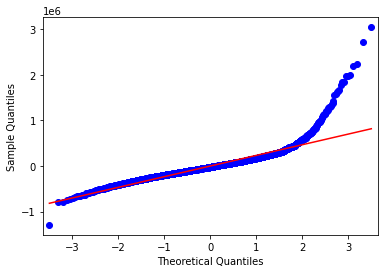

In [41]:
qq(X_test_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']],
   X_train_scaled[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']], y_test, y_train)

In [42]:
y_hat2 = model2.predict(X_train[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])
y_pred2 = model2.predict(X_test[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])

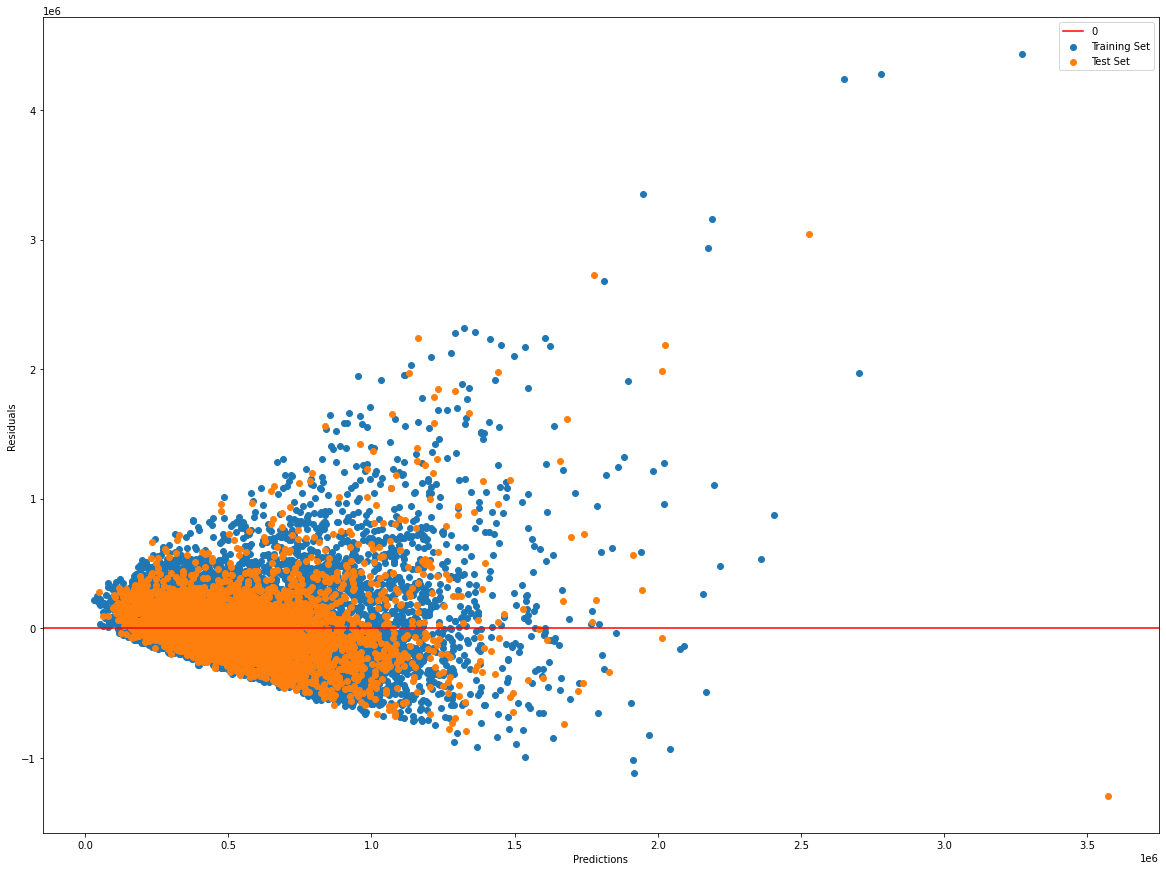

In [43]:
plt.figure(figsize = (20,15))
plt.scatter(y_hat2, y_train - y_hat2, label = 'Training Set')
plt.scatter(y_pred2, y_test - y_pred2, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

After we check for heteroskedasticity, we identified a similar "funnel" pattern in our dataset. This led us to believe that the data is not being scaled correctly, so we took the log of the data and plotted the data below to visualize a more normal distribution of our findings.

In [44]:
ylog_test2 = np.log(abs(y_pred2))
ylog_train2 = np.log(abs(y_hat2))

plt.figure(figsize = (20,15))
plt.scatter(ylog_train2, np.log(abs(y_train)) - ylog_train2, label = 'Training Set')
plt.scatter(ylog_test2, np.log(abs(y_test)) - ylog_test2, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
model2.params

Intercept          -193006.506017
sqft_living            240.597198
sqft_per_bedroom       248.739665
footprint           106212.265597
bedbathratio         25613.591120
dtype: float64

We run the defined function `sm_metrics` to compare the RMSE values of our training and test dataset, and we identified that the RMSE values are relatively close between the training dataset and the test dataset. The margin of error is still decently high; however, compared to our base model, our new model is more efficient.

In [46]:
sm_metrics(model2, y_train, X_train)

Metrics:
Mean Absolute Error: 170311.199
Mean Squared Error: 67468439768.192
Root Mean Squared Error: 259746.876


In [47]:
sm_metrics(model2, y_test, X_test)

Metrics:
Mean Absolute Error: 168308.110
Mean Squared Error: 64746046225.220
Root Mean Squared Error: 254452.444


In conclusion, this 2nd model produced an R^2 value of 0.502 and an RMSE of about 260,000. Compared to our first model, this model is more efficient since we utilize less variables and still get about the same R^2 value.

## Third Model - focusing on sqft_living and sqft_per_bedroom

We recognize that sqft_living is one of the most important factors that we extrapolated from this model and our dataset. We decided to run a new model that focused primarily on the sqft_living predictors and the sqft_per_bedroom predictor that we engineered to see if this would produce a better model or not.

In [48]:
formula3 = 'price ~  sqft_living + sqft_per_bedroom'
model3 = ols(formula3, X_train_plus_y).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     8510.
Date:                Sun, 20 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:36:43   Log-Likelihood:            -2.4001e+05
No. Observations:               17277   AIC:                         4.800e+05
Df Residuals:                   17274   BIC:                         4.801e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9.454e+04   6031.466    -15.674      0.000   -1.06e+05   -8.27e+04
sqft_living        245.5396      3.335     73.615      0.000     239.002     252.077
sqft_per_bedroom   201.1258     14.132     14.232      0.000     173.425     228.826
==============================================================================
Omnibus:                    12274.680   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           520725.641
Skew:                           2.925   Prob(JB):                         0.00
Kurtosis:                      29.251   Cond. No.                     7.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After running our model, we get a R^2 value of 0.496. The fact that model produces an R^2 value of 0.496 with only two predictors signifies that sqft has a significant impact on the variation of the price of a home. The coefficients of our predictors in this model are reasonable numbers.

In [49]:
sm_metrics(model3, y_train, X_train)

Metrics:
Mean Absolute Error: 172693.467
Mean Squared Error: 68246302116.105
Root Mean Squared Error: 261239.932


In [50]:
sm_metrics(model3, y_test, X_test)

Metrics:
Mean Absolute Error: 170805.475
Mean Squared Error: 65423939839.562
Root Mean Squared Error: 255781.039


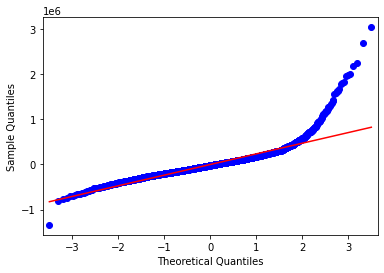

In [51]:
qq(X_test_scaled[['sqft_living', 'sqft_per_bedroom']],
   X_train_scaled[['sqft_living', 'sqft_per_bedroom']], y_test, y_train)

In [52]:
y_hat3 = model3.predict(X_train[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])
y_pred3 = model3.predict(X_test[['sqft_living', 'sqft_per_bedroom', 'footprint', 'bedbathratio']])

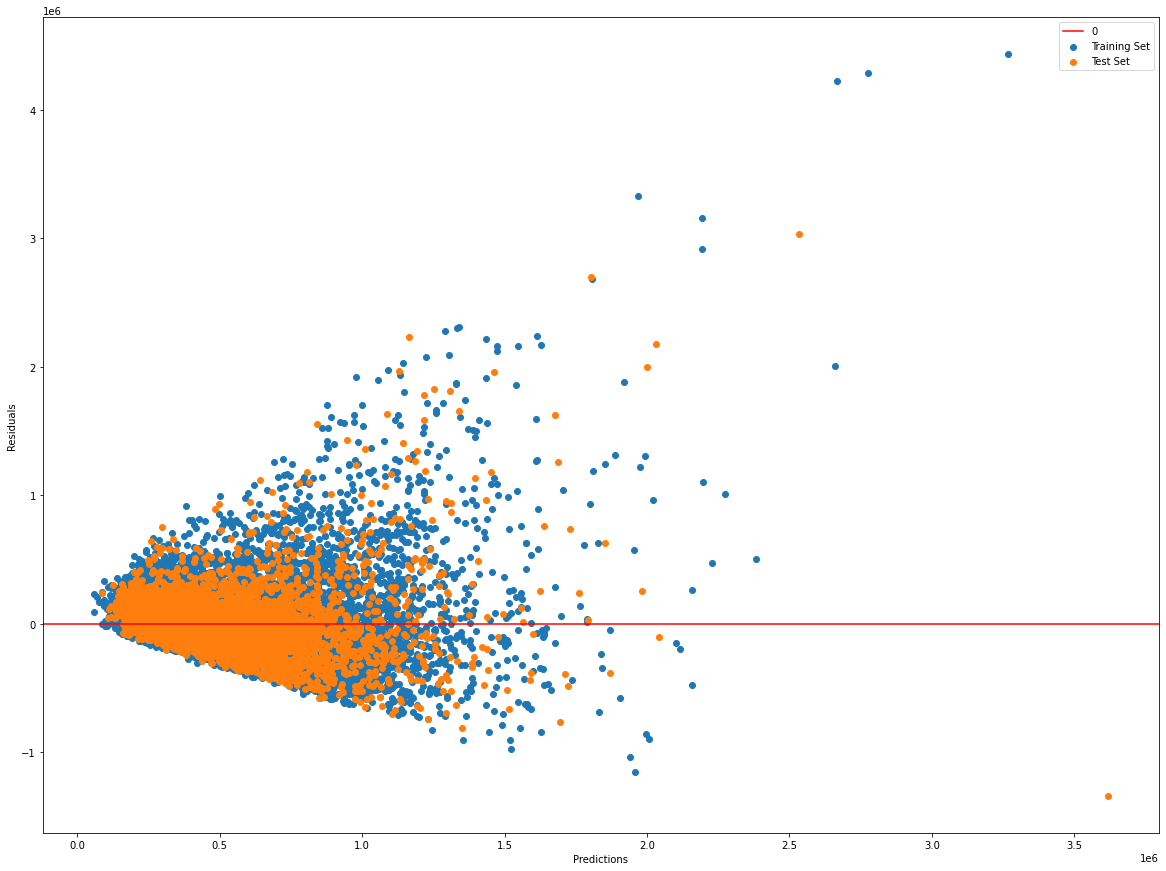

In [53]:
plt.figure(figsize = (20,15))
plt.scatter(y_hat3, y_train - y_hat3, label = 'Training Set')
plt.scatter(y_pred3, y_test - y_pred3, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [54]:
ylog_test3 = np.log(abs(y_pred3))
ylog_train3 = np.log(abs(y_hat3))

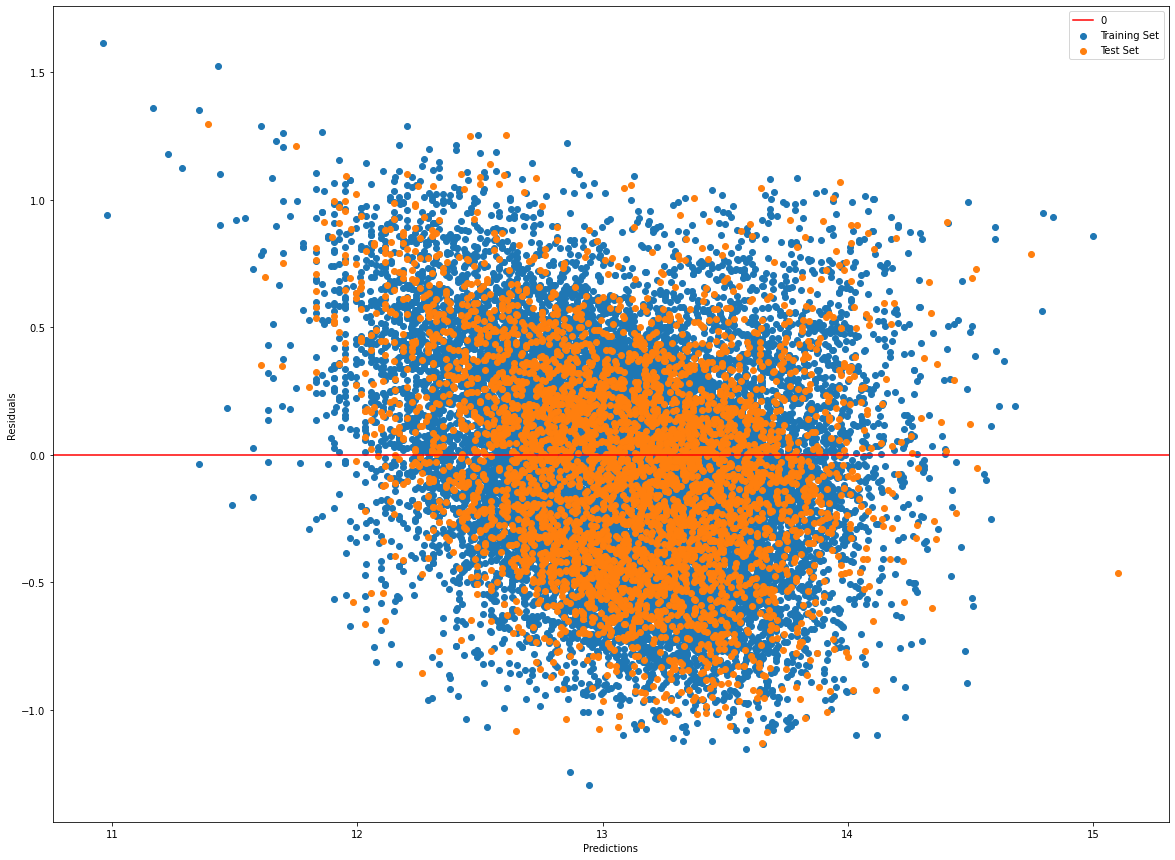

In [55]:
plt.figure(figsize = (20,15))
plt.scatter(ylog_train3, np.log(abs(y_train)) - ylog_train3, label = 'Training Set')
plt.scatter(ylog_test3, np.log(abs(y_test)) - ylog_test3, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

After performing the log on our datasets, the residuals appear normalized when we look at the scatter plot; however, the coefficients that are produced are outside the domains available for log transformation, so we do not utilize these coefficients in our analysis. Instead we decided to utilize the predictors without log-scaling. The rest of the models and plots we produce will utilize similar logging to normalize the heteroskedasticity plots for better visualization, but it is unlikely that we will continue to utilize this process in our analysis. 

## Fourth Model - implementing categorical variables 

This model implements the categorical variables 'grade' and 'zipcode' that we identified in our datasets. We want to run this model to see if the categorical predictors that we identified from our dataset have a significant influence on the price of a home or not.

In [56]:
y1 = dfrev2['price']
X1 = dfrev2[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode', 'grade']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=56)

Created a DummyRegressor in similar fashion to the one made for the three models above.

In [57]:
X1_train_cont = X1_train.drop(['zipcode', 'grade'], axis = 1).copy()
X1_test_cont = X1_test.drop(['zipcode', 'grade'], axis = 1).copy()
ss1 = StandardScaler()
ss1.fit(X1_train_cont)

X1_train_scaled = ss1.transform(X1_train_cont)
X1_test_scaled = ss1.transform(X1_test_cont)

#Dummy Regressor

basemodel1 = DummyRegressor(strategy = 'mean')
basemodel1.fit(X1_train, y1_train)
basemodel1.predict(X1_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

Dropped the numerical columns from our dataframe so that we could only focus on and OneHotEncode the categorical values we pulled from our demographics XLS

In [58]:
X1_cat = X1_train[['zipcode', 'grade']]
ohe1 = OneHotEncoder(sparse = False)
ohe_df = pd.DataFrame(ohe1.fit_transform(X1_cat))

In [59]:
ohe_df.columns = ohe1.get_feature_names(['zipcode', 'grade'])

In [60]:
X1_train_df = pd.DataFrame(X1_train_scaled)
X1_train_df.columns = X1_train_cont.columns.tolist()

In [61]:
X1_train_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192
1,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897
2,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307
3,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770
4,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379
...,...,...,...,...,...,...
17272,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180
17273,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529
17274,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939
17275,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325


In [62]:
ohe_df.head()

,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,zipcode_West,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Created a dataframe with the new OHE values for our categorical columns from housedf, and we added the price column from our original dataframe to the OHE dataframe to check for correlation between these variables and if they had an effect on home pricing.

In [63]:
combined_df = ohe_df.join(X1_train_df)
X_train_predictors = combined_df.copy()
combined_df['price'] = y_train
combined_df

,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,zipcode_West,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,...,grade_7 Average,grade_8 Good,grade_9 Better,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192,525000.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897,469950.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307,436000.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770,900000.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379,835000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17272,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180,375000.0
17273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529,810000.0
17274,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939,935000.0
17275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325,269900.0


In [64]:
# Before running our model, run correlation to check for multicollinearity.
combined_df.corr()

,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,zipcode_West,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,...,grade_7 Average,grade_8 Good,grade_9 Better,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price
zipcode_Northeast,1.000000,-0.229578,-0.392327,-0.317999,-0.414327,0.164717,0.117355,0.053578,0.007630,0.001459,...,-0.159235,0.043572,0.158288,0.175478,0.273140,0.317908,0.110997,0.108523,0.360141,0.250924
zipcode_Shoreline,-0.229578,1.000000,-0.136507,-0.110646,-0.144162,-0.055653,-0.037506,-0.007378,0.019168,-0.010541,...,0.067950,-0.013586,-0.060654,-0.038443,-0.103396,-0.083594,-0.042083,-0.094373,-0.092777,-0.061293
zipcode_Southeast,-0.392327,-0.136507,1.000000,-0.189083,-0.246360,-0.077874,-0.054909,-0.028241,-0.012191,0.013731,...,0.100784,-0.026789,-0.066623,0.010241,-0.060813,-0.085776,0.048762,-0.090932,0.090581,-0.304331
zipcode_Southwest,-0.317999,-0.110646,-0.189083,1.000000,-0.199686,-0.067689,-0.041655,-0.016679,-0.009881,0.008289,...,0.020687,-0.065107,-0.077702,-0.093382,-0.154872,-0.152231,-0.029336,-0.127626,-0.137272,-0.188512
zipcode_West,-0.414327,-0.144162,-0.246360,-0.199686,1.000000,-0.031053,-0.029576,-0.018695,-0.001537,-0.015185,...,0.033725,0.036626,-0.022535,-0.118899,-0.074663,-0.119657,-0.129568,0.124829,-0.347961,0.188803
grade_10 Very Good,0.164717,-0.055653,-0.077874,-0.067689,-0.031053,1.000000,-0.033026,-0.015104,-0.006020,-0.008896,...,-0.202216,-0.148667,-0.087976,0.134485,0.275956,0.374500,0.071095,0.178003,0.149032,0.351003
grade_11 Excellent,0.117355,-0.037506,-0.054909,-0.041655,-0.029576,-0.033026,1.000000,-0.008768,-0.003495,-0.005164,...,-0.117388,-0.086302,-0.051071,0.112923,0.251408,0.350728,0.079896,0.119179,0.101321,0.356556
grade_12 Luxury,0.053578,-0.007378,-0.028241,-0.016679,-0.018695,-0.015104,-0.008768,1.000000,-0.001598,-0.002362,...,-0.053685,-0.039468,-0.023356,0.062151,0.145078,0.228029,0.054208,0.046614,0.041757,0.290280
grade_13 Mansion,0.007630,0.019168,-0.012191,-0.009881,-0.001537,-0.006020,-0.003495,-0.001598,1.000000,-0.000941,...,-0.021399,-0.015732,-0.009310,0.039099,0.100498,0.146305,0.008806,0.019414,0.007181,0.213442
grade_4 Low,0.001459,-0.010541,0.013731,0.008289,-0.015185,-0.008896,-0.005164,-0.002362,-0.000941,1.000000,...,-0.031620,-0.023247,-0.013757,-0.070167,-0.058348,-0.056892,-0.000789,-0.031337,-0.046192,-0.034023


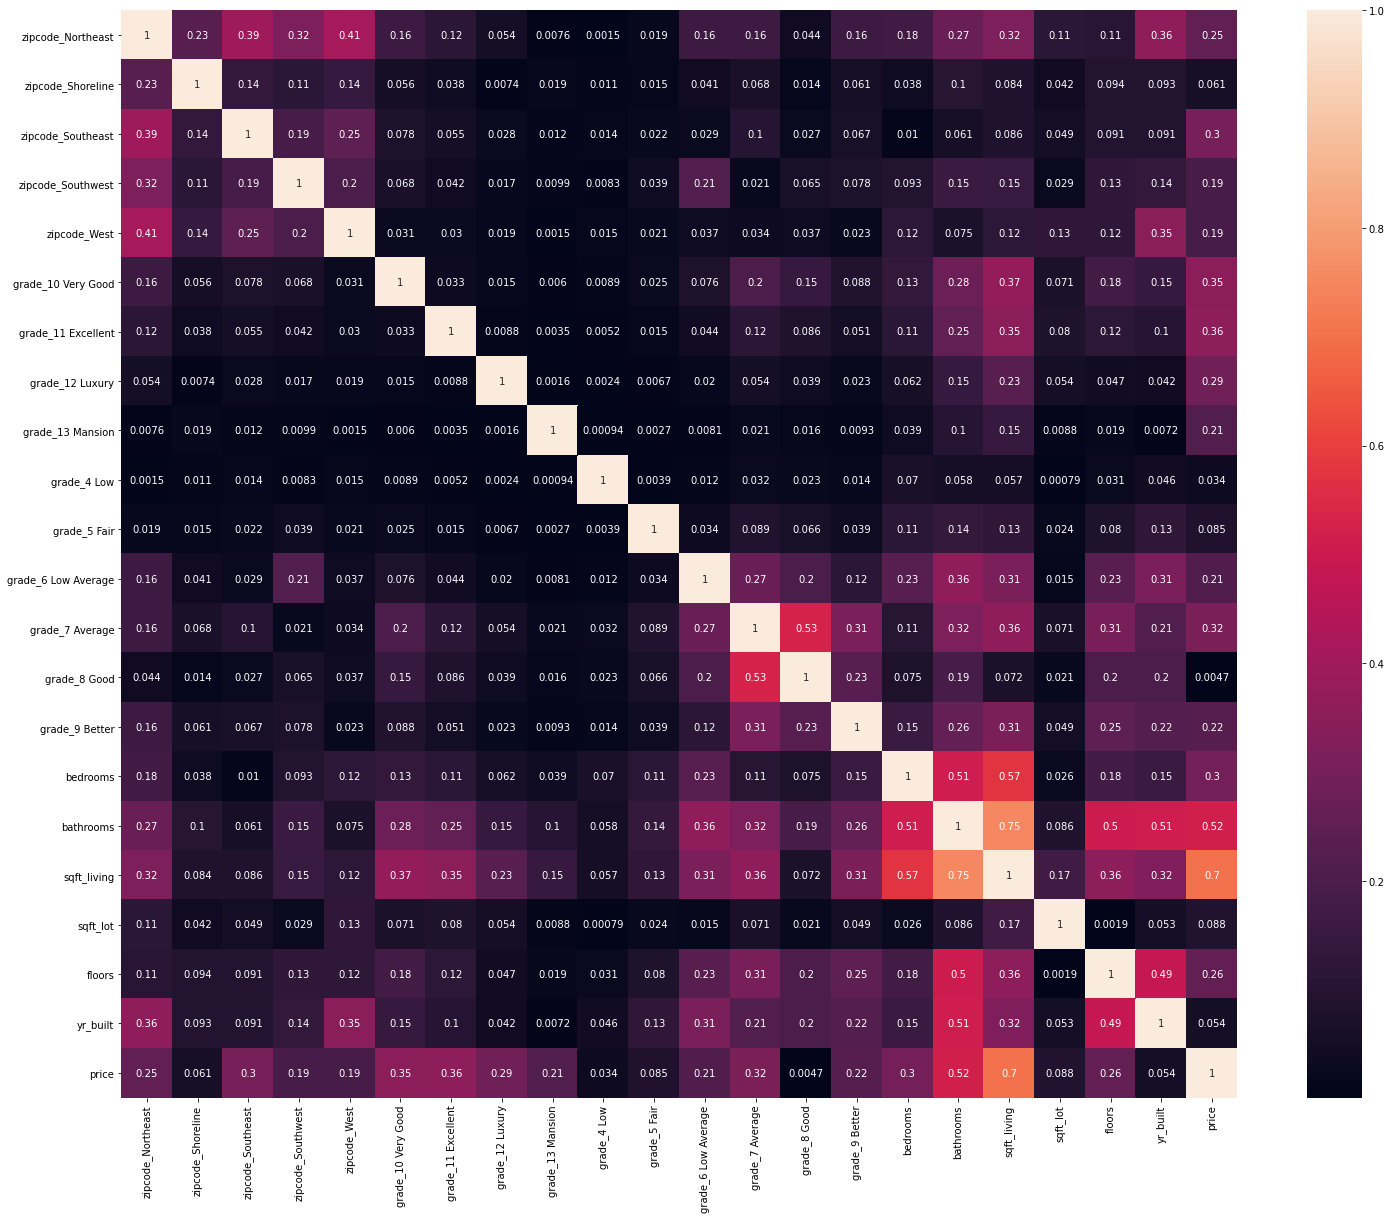

In [65]:
# Run a heatmap to better visualize the correlation between the variables that we identified, StandardScaled, and OneHotEncoded
plt.figure(figsize = (25, 20))
sns.heatmap(combined_df.corr().abs(), annot=True);

As we can see from the `df_corrs` and the heatmap generated above, there is some correlation between the categorical variables we identified (grade/zipcode/floors) and their effect on price.

After we check the correlation and multicollinearity, we can now run a model on the variables on these variables.

In [66]:
lr = LinearRegression()
model4 = lr.fit(X_train_predictors, y_train)
model4.score(X_train_predictors, y_train)

0.7016031747477318

In [67]:
y_pred_model = lr.predict(X_train_predictors.values)

In [68]:
sk_metrics(y_train, y_pred_model)

Metrics:
R2: 0.702
Mean Absolute Error: 118807.607
Mean Squared Error: 40430372946.267
Root Mean Squared Error: 201073.054


In [69]:
lr_model_metrics(X1_test, X1_train, y1_test, y1_train, ['grade','zipcode']);

Train Data
Metrics:
R2: 0.702
Mean Absolute Error: 118783.298
Mean Squared Error: 40429737661.469
Root Mean Squared Error: 201071.474
Test Data
Metrics:
R2: 0.702
Mean Absolute Error: 118921.240
Mean Squared Error: 39508992531.045
Root Mean Squared Error: 198768.691


The R^2 of this model is 0.702. This has been our best performing model; however, it has the most predictors associated with the model, so we want to run a few more models and check to see if we can optimize and simplify the model to utilize less predictors while covering for as much of the variation in price as possible.

## Fifth Model - incorporating features from previous model and the 'grade' feature

Created a new test/train split with the predictors that we want to focus on. 

In [70]:
y5 = dfrev2['price']
X5 = dfrev2[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'grade']]
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=56)

In [71]:
# Define cat_vars
cat_vars = ['grade']

x5_train = pd.DataFrame()
x5_test = pd.DataFrame()
x5_train = X5_train[cat_vars]
x5_train['ID'] = 1
x5_test = X5_test[cat_vars]
x5_test['ID'] = 1

# One hot encoding cat vars
onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
x_train_cat = pd.DataFrame(onehot.fit_transform(x5_train))
x_train_cat.columns = onehot.get_feature_names(x5_train.columns.tolist())
x_test_cat = pd.DataFrame(onehot.transform(x5_test))
x_test_cat.columns = onehot.get_feature_names(x5_train.columns.tolist())

# Drop ID column
x_train_cat.drop(['ID_1'], axis=1, inplace=True)
x_test_cat.drop(['ID_1'], axis=1, inplace=True)
    
# Resetting indices
x_train_cat.reset_index(drop=True, inplace=True)
x_test_cat.reset_index(drop=True, inplace=True)
X5_train.reset_index(drop=True, inplace=True)
X5_test.reset_index(drop=True, inplace=True)
    
# Combine dummied cat vars with non-cat
x_train_df = x_train_cat.join(X5_train.drop(cat_vars, axis = 1))
x_test_df = x_test_cat.join(X5_test.drop(cat_vars, axis = 1))

<ipython-input-71-0da3b2a3dac0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x5_train['ID'] = 1
<ipython-input-71-0da3b2a3dac0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x5_test['ID'] = 1


In [72]:
x_train_df

,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,2.00,1540,7800,1.0,2004
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,2.75,2530,14178,2.0,1997
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,2.25,1800,6680,2.0,1983
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,2.50,2660,3672,2.0,1910
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,2.75,4030,10240,2.0,1943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,2.25,1640,2240,2.0,1980
17273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,3.25,3290,6422,2.0,2012
17274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3.25,3710,38509,2.0,1998
17275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1.75,1530,8750,1.5,1968


After we ran the model, we checked the score value of the training set vs the test set. We also doublecheck the metrics to see if there are any differences we failed to identify.

In [73]:
lr = LinearRegression()
model5 = lr.fit(x_train_df, y5_train)
model5.score(x_train_df, y5_train)

0.644614517676586

In [74]:
model5.score(x_test_df, y5_test)

0.6448091772630099

In [75]:
sk_metrics(y5_train, model5.predict(x_train_df))

Metrics:
R2: 0.645
Mean Absolute Error: 140500.728
Mean Squared Error: 48151878217.462
Root Mean Squared Error: 219435.362


In [76]:
sk_metrics(y5_test, model5.predict(x_test_df))

Metrics:
R2: 0.645
Mean Absolute Error: 140062.150
Mean Squared Error: 47165636238.606
Root Mean Squared Error: 217176.509


After running this model, we see that the R^2 value is 0.645. The R^2 valued decreased by about 6%. This leads us to believe that zipcode has a decent significance in the variation of the housing price. 

In [77]:
print(x_test_df.columns)
print(model5.coef_)

Index(['grade_10 Very Good', 'grade_11 Excellent', 'grade_12 Luxury',
       'grade_13 Mansion', 'grade_4 Low', 'grade_5 Fair',
       'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good',
       'grade_9 Better', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'yr_built'],
      dtype='object')
[-2.69101389e+04  2.34921054e+05  8.03776296e+05  1.81228481e+06
 -6.13175604e+05 -5.98404401e+05 -5.50234177e+05 -4.63710683e+05
 -3.68105276e+05 -2.30441881e+05 -3.39039328e+04  5.81524173e+04
  1.54814698e+02 -2.61255318e-01  2.67150446e+04 -3.85123851e+03]


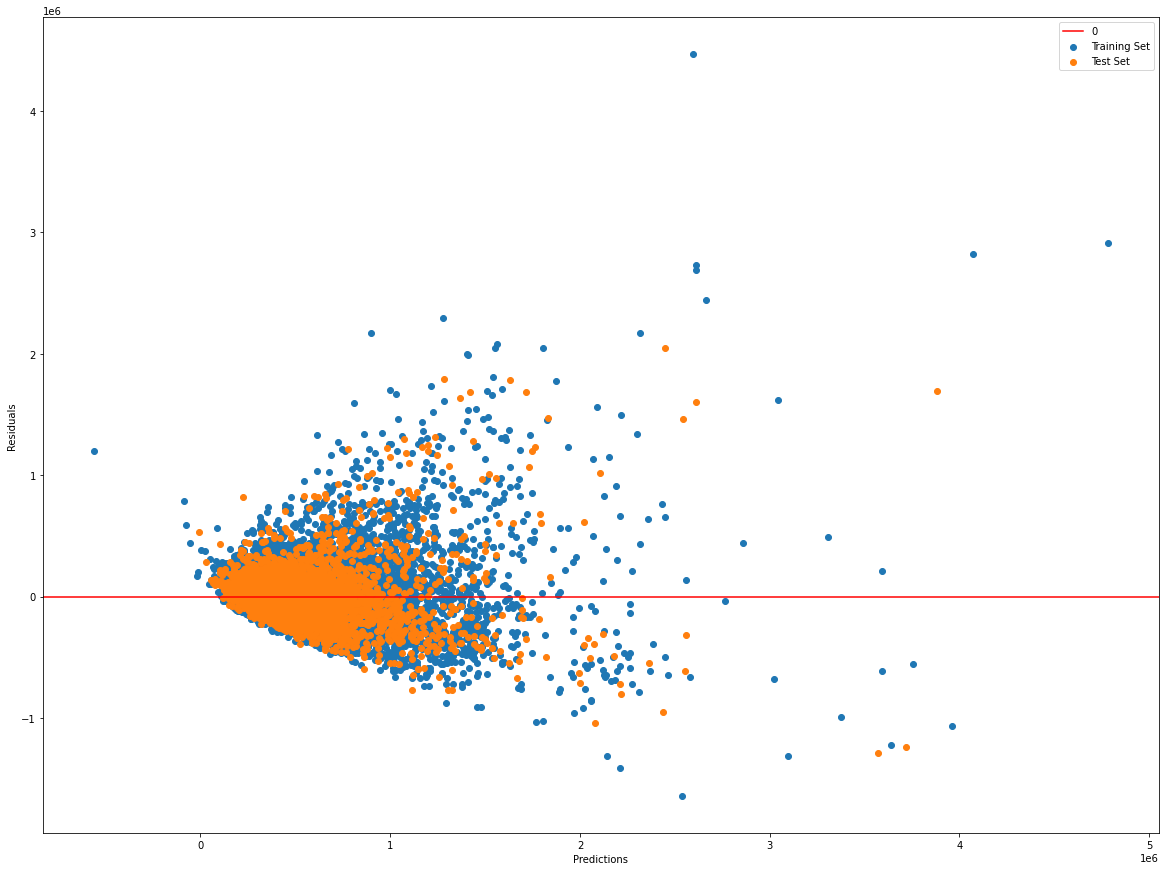

In [78]:
plt.figure(figsize = (20,15))
plt.scatter(model5.predict(x_train_df), y5_train - model5.predict(x_train_df), label = 'Training Set')
plt.scatter(model5.predict(x_test_df), y5_test - model5.predict(x_test_df), label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

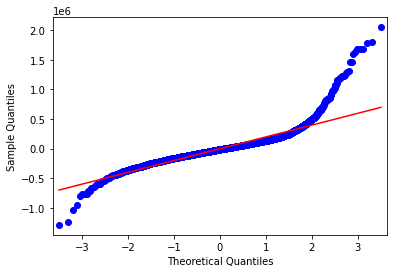

In [79]:
qq(x_test_df, x_train_df, y5_test, y5_train)

After we ran our model, we ran a qqplot and heteroskedasticity check to see if there were any huge errors in our modeling. We recognize that there is a pattern in most of our data that is likely attributed to the lack of normal distribution between of our data(it is data from only one year after all.) 

We recognize that the model is a good model since the RMSE values are not extranously high. This model also utilizes less predictors, so we can conclude that this model is more efficient than our previous model; however, we can run one more model to optimze the use of predictors to provide the best model for this data.

## Sixth Model - Modeling with ONLY sqft_living, zipcode, and grade of homes

After we ran the previous model, we wanted to create a final model to explore the significance of just the three most important predictors that we have identified over the course of our analysis and modeling: '**sqft_living**', '**zipcode**', and '**grade**'.

In [80]:
y6 = dfrev2['price']
X6 = dfrev2[['sqft_living', 'zipcode', 'grade']]
x6_train, x6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=56)

In [81]:
# Onehot encode

# Define cat_vars
cat_vars = ['grade', 'zipcode']


# One hot encoding cat vars
onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
x6_train_cat = pd.DataFrame(onehot.fit_transform(x6_train[cat_vars]))
x6_train_cat.columns = onehot.get_feature_names(cat_vars)
x6_test_cat = pd.DataFrame(onehot.transform(x6_test[cat_vars]))
x6_test_cat.columns = onehot.get_feature_names(cat_vars)
    
# Resetting indices
x6_train_cat.reset_index(drop=True, inplace=True)
x6_test_cat.reset_index(drop=True, inplace=True)
x6_train.reset_index(drop=True, inplace=True)
x6_test.reset_index(drop=True, inplace=True)
    
# Combine dummied cat vars with non-cat
x6_train_df = x6_train_cat.join(x6_train.drop(cat_vars, axis = 1))
x6_test_df = x6_test_cat.join(x6_test.drop(cat_vars, axis = 1))

In [82]:
# Run regression

lr = LinearRegression()
model6 = lr.fit(x6_train_df, y6_train)
model6.score(x6_train_df, y6_train)

0.6792846894781521

In [83]:
model6.score(x6_test_df, y6_test)

0.6803566979982765

As you can see, this final model provided us with an R^2 value of 0.680, which is significantly better than our initial model that we produced with just the continuous data. After checking the R^2 value, we need perform a qqplot and heteroskedasticity check to identify normal distribution within our modeling.

In [84]:
vif(x6_train_df)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF             features
0        inf   grade_10 Very Good
1        inf   grade_11 Excellent
2        inf      grade_12 Luxury
3        inf     grade_13 Mansion
4        inf          grade_4 Low
5        inf         grade_5 Fair
6        inf  grade_6 Low Average
7        inf      grade_7 Average
8        inf         grade_8 Good
9        inf       grade_9 Better
10       inf    zipcode_Northeast
11       inf    zipcode_Shoreline
12       inf    zipcode_Southeast
13       inf    zipcode_Southwest
14       inf         zipcode_West
15  2.583583          sqft_living


In [85]:
sk_metrics(y6_train, model6.predict(x6_train_df))

Metrics:
R2: 0.679
Mean Absolute Error: 123400.864
Mean Squared Error: 43454348426.844
Root Mean Squared Error: 208457.066


In [86]:
sk_metrics(y6_test, model6.predict(x6_test_df))

Metrics:
R2: 0.680
Mean Absolute Error: 122776.053
Mean Squared Error: 42445296283.693
Root Mean Squared Error: 206022.563


Once again we checked the metrics and we can see that the RMSE of this last model is signficantly lower than the RMSE of our baseline model. Since these values are relatively low, we can conclude that our models are not overfit on the dataset and that the **predictors 'sqft_living', 'zipcode', and 'grade' account for ~68% of the variation in the price of a home.**

In [87]:
print(x6_test_df.columns)
print(model6.coef_)

Index(['grade_10 Very Good', 'grade_11 Excellent', 'grade_12 Luxury',
       'grade_13 Mansion', 'grade_4 Low', 'grade_5 Fair',
       'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good',
       'grade_9 Better', 'zipcode_Northeast', 'zipcode_Shoreline',
       'zipcode_Southeast', 'zipcode_Southwest', 'zipcode_West',
       'sqft_living'],
      dtype='object')
[-1.21259720e+05  1.27964757e+05  6.96803430e+05  1.74215418e+06
 -4.08425392e+05 -4.41443189e+05 -4.28565748e+05 -4.44161409e+05
 -4.10033064e+05 -3.13033841e+05  2.06300341e+04  1.09723229e+04
 -1.59947475e+05 -6.95254609e+04  1.97870579e+05  1.78539231e+02]


We once again plot the heteroskedasticity and qqplot to check for normal distribution within our predictors and dataframe.

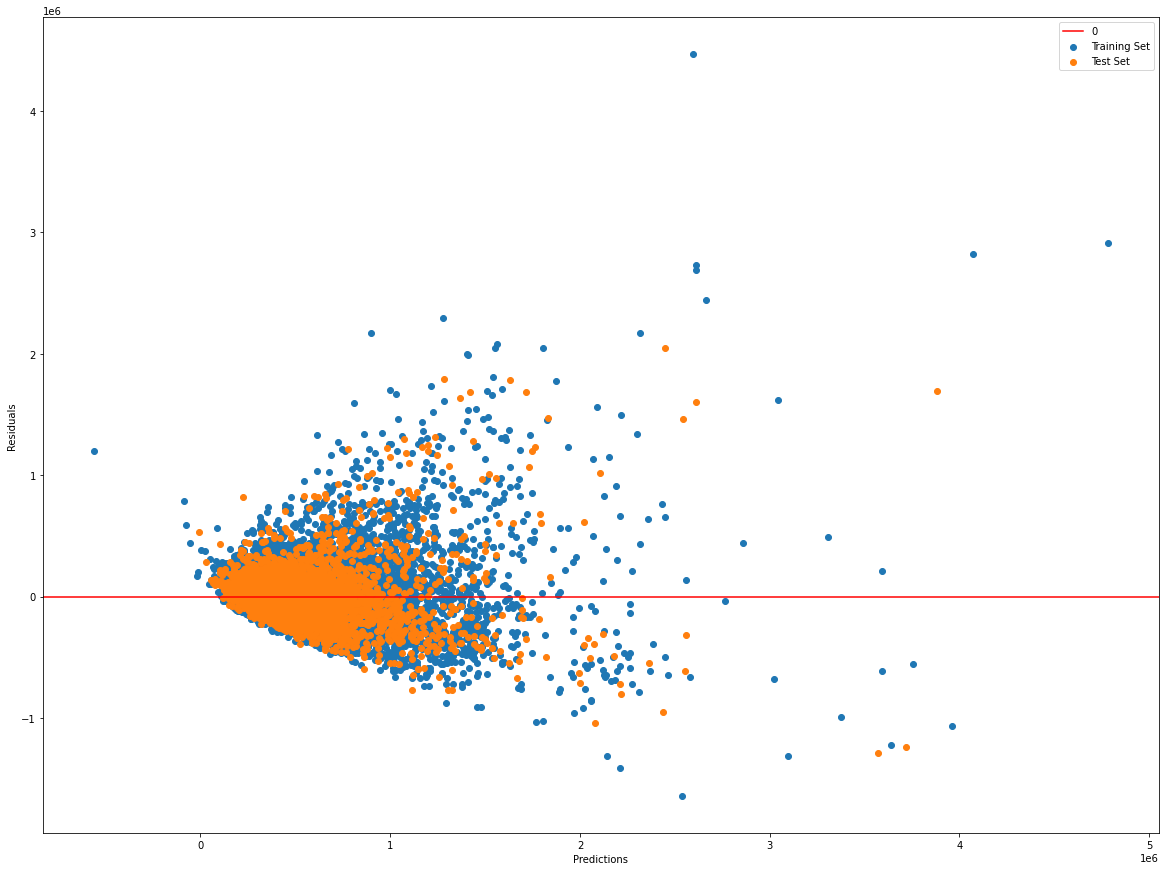

In [88]:
plt.figure(figsize = (20,15))
plt.scatter(model5.predict(x_train_df), y5_train - model5.predict(x_train_df), label = 'Training Set')
plt.scatter(model5.predict(x_test_df), y5_test - model5.predict(x_test_df), label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

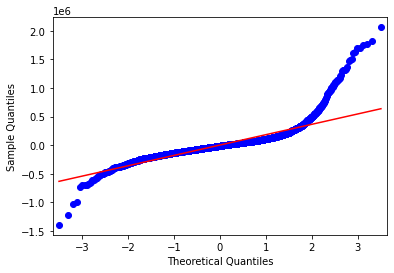

In [89]:
qq(x6_test_df, x6_train_df, y6_test, y6_train)

# Visualizations

We decided to extrapolate the data that we produced from our modeling and created bargraphs for easier visualization of our main points about the sqft_living, zipcode(region), grade(condition) and their significance in home pricing.

In [90]:
# Binning living space by house size as per National Association of Home Builder (NAHB) classifications

living_price = housedf[['sqft_living', 'price']]

bins = [1., 2000., 3000., 4000., 14000]
bin_labels = ['Small House', 'Medium House', 'Large House', 'Bigger Houses']

living_price['bins'] = pd.cut(x=living_price['sqft_living'], bins=bins, labels=bin_labels)

<ipython-input-90-44b9be3c1b63>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  living_price['bins'] = pd.cut(x=living_price['sqft_living'], bins=bins, labels=bin_labels)


Text(0, 0.5, 'Price (USD)')

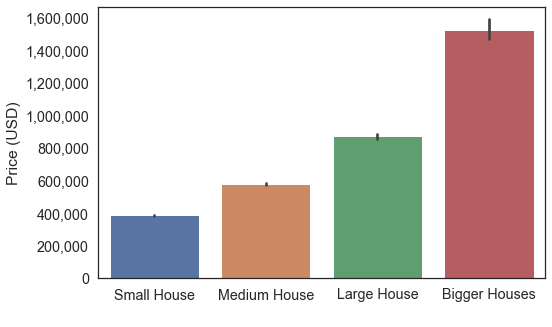

In [91]:
# Plot living area bins versus price
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.3, style="white")
v = sns.barplot(x='bins', y='price', data=living_price)
v.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
v.set_xlabel(" ")
v.set_ylabel("Price (USD)")

Text(0, 0.5, 'Price (USD)')

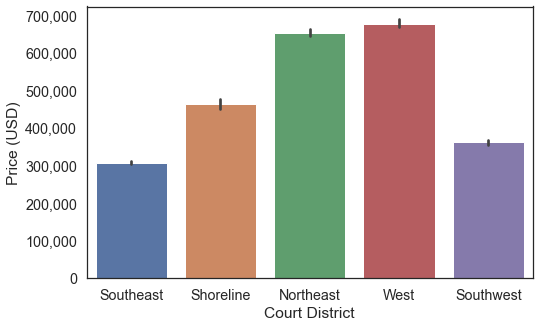

In [92]:
# Plot price by region
region_price = dfrev2[['zipcode', 'price']]

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.3, style="white")
v = sns.barplot(x='zipcode', y='price', data=region_price)
v.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
v.set_xlabel("Court District")
v.set_ylabel("Price (USD)")

In [93]:
# Plot price by grade

# Bin grades
grade_price = housedf[['price','grade']]

grade_def = {'4 Low': 'Low', '3 Poor': 'Low', '6 Low Average': 'Low', '5 Fair' : 'Low' ,  '7 Average': 'Medium', '8 Good': 'High', '9 Better': 'High', '10 Very Good': 'High', '11 Excellent': 'Outstanding', '12 Luxury': 'Outstanding', '13 Mansion': 'Outstanding'}



grade_price['grade'] = grade_price['grade'].map(grade_def)

grade_price['grade'].value_counts().sum()

<ipython-input-93-8c42c9c7613c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grade_price['grade'] = grade_price['grade'].map(grade_def)


21597

Text(0, 0.5, 'Price (USD)')

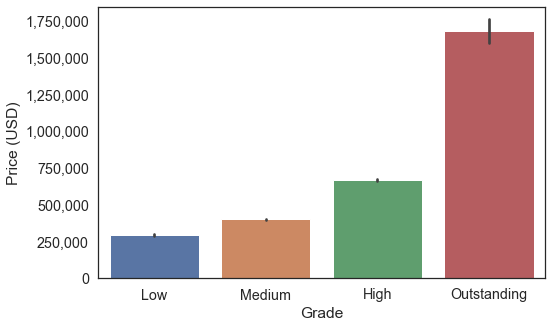

In [94]:
# Plot price by grade

grade_order= ['Low', 'Medium', 'High', 'Outstanding']

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.3, style="white")
v = sns.barplot(x='grade', y='price', data=grade_price, order=grade_order)
v.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
v.set_xlabel("Grade")
v.set_ylabel("Price (USD)")

# Conclusion


Our business stakeholder is Howard S Wright construction company, and they are trying to build new homes in King County that will maximize their sale profit.

<br />

We identified these **three important factors** that HSW should consider when building a new home:

- **Square Footage**
- **Region to build in (zipcode)**
- **Quality of the home** 


We ran multiple multilinear regression models, and in our final model (which utilized only three predictors and produced an R^2 value that was 2% less than the model that utilized eight predictors)  we identified that the three predictors listed above account for **68% of the variation in the price of home** in King County.

## Recommendations

Based on these findings we recommend that Howard S Wright:
- **Build more homes in the West region.**
- **Maximize the square footage while minimizing construction expenses.**
    - For instance, two floor homes are generally cheaper to build and we found little correaltion between number of floors and sale price.
- **Build quality homes - to a certain extent. Less than 1% of the homes that we identified are in the top tier of quality homes.**

## Future Considerations

- One component of demographics is population growth and growth has been strongest in the West region.
- We can dive further into buyer demographics and how it impacts the demand side of the equation.
- Consider the benefits of eco friendly building techniques and materials.
- Examine construction costs and how closely they are linked with sale price.
